In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.cluster import KMeans
from scipy.signal import find_peaks

def find_outlier_indices(data):
	Q1 = np.percentile(data, 25)
	Q3 = np.percentile(data, 75)
	IQR = Q3 - Q1
	multiplier = 1.5
	return np.where((data < (Q1 - multiplier * IQR)) | (data > (Q3 + multiplier * IQR)))[0]

def normalize_image(image):
	min_val = np.min(image)
	max_val = np.max(image)
	normalized_image = (image - min_val) / (max_val - min_val)
	return (normalized_image * 255).astype(np.uint8)

def add_without_blend(img1, img2):
	return np.where(np.any(img2>0,axis=-1,keepdims=True), img2, img1)   

In [2]:

def extract_mean_black_key_distances(data):
	x = np.array(data)
	km = KMeans(2)
	y = x.reshape(-1 ,1)
	km.fit(y)
	far_index = km.cluster_centers_.argmax()
	near_index = 1 - far_index
	return km.cluster_centers_[near_index][0], km.cluster_centers_[far_index][0]

def get_w_b_keys_masks(image_grayscale):
	_, otsu_mask = cv2.threshold(image_grayscale, 0, 255, cv2.THRESH_OTSU)
	otsu_mask = piecewise_otsu_thresholding(image_grayscale)
	kernel_size = 3
	kernel = np.ones((kernel_size*4, kernel_size*2), np.uint8)
	closed_mask = cv2.morphologyEx(otsu_mask, cv2.MORPH_CLOSE, kernel)

	white_key_mask = cv2.morphologyEx(closed_mask, cv2.MORPH_OPEN, kernel)
	black_key_mask = (255 - white_key_mask)
	return white_key_mask, black_key_mask

def extract_black_key_info(black_key_mask):
	num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(black_key_mask, connectivity=4)
	delta_x_to_previous = []
	outliers_by_area = find_outlier_indices(stats[:, cv2.CC_STAT_AREA])
	modified_range = np.delete(range(0, num_labels), outliers_by_area)
	black_keys_bb = []

	for i in modified_range:
		if i in outliers_by_area:
			continue
		x = stats[i, cv2.CC_STAT_LEFT]
		y = stats[i, cv2.CC_STAT_TOP]
		w = stats[i, cv2.CC_STAT_WIDTH]
		h = stats[i, cv2.CC_STAT_HEIGHT]
		(cX, cY) = centroids[i]
		black_keys_bb.append((x,y,x+w,y+h))
		
		if i != modified_range[0]:
			(xP, yP) = centroids[i-1]
			delta_x_to_previous.append(cX - xP)
	return black_keys_bb, delta_x_to_previous

def apply_sobel(image_grayscale, mask):
	kernel_size = (15, 10)
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
	extended_mask = cv2.erode(mask, kernel, iterations=1)
	sobelx = cv2.Sobel(image_grayscale, cv2.CV_64F, 1, 0, ksize=3)
	sobelx_magnitude = np.uint8(255 * np.absolute(sobelx) / np.max(np.absolute(sobelx)))
	return cv2.bitwise_and(sobelx_magnitude, sobelx_magnitude, mask=extended_mask)

def piecewise_otsu_thresholding(input):
	h, w = input.shape

	chunk_size = (int(w / 5), int(h / 5))
	mask = np.zeros_like(input, dtype=np.uint8)

	for y in range(0, h, chunk_size[1]):
		for x in range(0, w, chunk_size[0]):
			roi = input[y:y+chunk_size[1], x:x+chunk_size[0]]
			
			_, chunk_mask = cv2.threshold(roi, 0, 255,cv2.THRESH_OTSU)
			
			mask[y:y+chunk_size[1], x:x+chunk_size[0]] = chunk_mask
	return mask

def generate_white_key_bb(seperators, image_height):
	result = []  
	for i in range(1, len(seperators)):
		result.append([seperators[i-1], 0, seperators[i], image_height])
	return result

def extract_white_key_bb(white_key_seperators_mask, black_key_near_distance):
	vertical_sum = np.sum(white_key_seperators_mask, axis=0)
	vertical_sum_normalized = vertical_sum / np.max(vertical_sum) * 255
	white_key_seperators, _ = find_peaks(vertical_sum_normalized, distance= black_key_near_distance * 0.5)
	white_key_seperators = np.append(white_key_seperators, white_key_seperators_mask.shape[1])
	white_key_seperators = np.insert(white_key_seperators, 0, 0)
	return generate_white_key_bb(white_key_seperators, white_key_seperators_mask.shape[0])

def generate_keys_dict(black_keys_bb, white_keys_bb):
	merged_list = []
	for black_key_bb in black_keys_bb:
		merged_list.append( {'x': black_key_bb[0], 'type': 'black', 'data': black_key_bb} )
	for white_key_bb in white_keys_bb:
		merged_list.append( {'x': white_key_bb[0], 'type': 'white', 'data': white_key_bb})
		
	sorted_keys = sorted(merged_list, key=sort_key)
	black, white = seperate_sorted_keys(sorted_keys)
	return sorted_keys, black, white

def sort_key(key_tuple):
	return key_tuple['x']

def seperate_sorted_keys(sorted_list):
	black = {}
	white = {}
	for i in range(len(sorted_list)):
		element = sorted_list[i]
		if element['type'] == 'white':
			white[i] = element['data']
		else:
			black[i] = element['data']
	return black, white

def find_first_fis_index(black_keys):
	for i in black_keys:
		if (i+2) in black_keys and (i+4) in black_keys:
			return i
	return None


def generate_piano_keys():
	notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
	keys = []
	
	for octave in range(0, 9):
		for note in notes:
			keys.append(f"{note}{octave}")
	return keys


def generate_labels(piano_labels, first_fis_reference):
	result = {}
	FIRST_FIS_REFERENCE_GT = 18
	offset = FIRST_FIS_REFERENCE_GT - first_fis_reference
	if offset < 0:
		offset += 12
	for i in range(offset, len(piano_labels)):
		result[i - offset] = piano_labels[i]
	return result    

def generate_overlay_segmentation(image, mask, labels, black_key_near_distance):

	image_with_edges = image.copy()
	
	for label in np.unique(mask):
		binary_mask = np.zeros(mask.shape, dtype=np.uint8)
		binary_mask[mask == label] = 255
		
		contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
		
		cv2.drawContours(image_with_edges, contours, -1, (0, 255, 0), 1)
		
		for contour in contours:
			M = cv2.moments(contour)
			if M["m00"] != 0:
				cx = int(M["m10"] / M["m00"])
				cy = int(M["m01"] / M["m00"])
				cv2.putText(image_with_edges, f"{labels[label]}", (cx - int(black_key_near_distance * 0.2), cy + int(black_key_near_distance)), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1)
	
	return image_with_edges

def process_background_image(image_bgr):

	image_grayscale = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
	image_height, image_width, image_channels = image_bgr.shape
	white_key_mask, black_key_mask = get_w_b_keys_masks(image_grayscale)
	black_keys_bb, delta_x_to_previous = extract_black_key_info(black_key_mask)
	black_key_near_distance, black_key_far_distance = extract_mean_black_key_distances(delta_x_to_previous)

	white_keys_vertical_edges = apply_sobel(image_grayscale, white_key_mask)
	white_key_seperators_mask = piecewise_otsu_thresholding(white_keys_vertical_edges)
	white_keys_bb = extract_white_key_bb(white_key_seperators_mask, black_key_near_distance)
	keys_dict, black_keys, white_keys = generate_keys_dict(black_keys_bb, white_keys_bb)

	piano_key_labels = generate_piano_keys()
	first_fis_index = find_first_fis_index(black_keys)
	
	segmentation = np.zeros_like(image_grayscale)

	for white_key_index, white_key_bb in white_keys.items():
		x_min, y_min, x_max, y_max = white_key_bb
		segmentation[y_min:y_max, x_min:x_max] = white_key_index

	for black_key_index, black_key_bb in black_keys.items():
		x_min, y_min, x_max, y_max = black_key_bb
		segmentation[y_min:y_max, x_min:x_max] = black_key_index

	labels = generate_labels(piano_key_labels, first_fis_index)
	keys_overlay = generate_overlay_segmentation(np.zeros_like(image_bgr), segmentation, labels, black_key_near_distance)
	return keys_overlay, keys_dict, labels, segmentation

In [3]:
def find_hand_and_shadow_mask(background, frame, generate_hand_bb = False):
	difference_image = cv2.absdiff(background, frame)

	# Convert difference image to grayscale
	gray_difference = cv2.cvtColor(difference_image, cv2.COLOR_BGR2GRAY)

	# Apply thresholding
	_, binary_mask = cv2.threshold(gray_difference, 30, 255, cv2.THRESH_BINARY)
	# Perform morphological operations
	kernel = np.ones((5, 5), np.uint8)
	kernel_stretch_x = np.ones((5, 15), np.uint8)
	kernel_stretch_y = np.ones((15, 5), np.uint8)
	binary_mask_closed = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
	binary_mask = cv2.morphologyEx(binary_mask_closed, cv2.MORPH_OPEN, kernel_stretch_x)
	binary_mask = cv2.dilate(binary_mask, kernel_stretch_y)
	overlay = cv2.merge([binary_mask, binary_mask, binary_mask])

	_, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
	x = stats[1:, cv2.CC_STAT_LEFT]
	w = stats[1:, cv2.CC_STAT_WIDTH]

	x_ranges_of_interest = ([(x[i], x[i]+w[i]) for i in range(len(x))])
		
	return overlay, binary_mask, x_ranges_of_interest
	

def detect_pressed_keys(keys, x_ranges_of_interest, segmentation, background_image, frame, hand_mask):
	result = []
	candidates = []
	metrics_w = []
	metrics_b = []
	border_mask_image = np.zeros_like(segmentation)

	bg_to_frame_delta = cv2.cvtColor(background_image, cv2.COLOR_BGR2GRAY).astype(np.int16) - cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.int16)
	frame_to_bg_delta = bg_to_frame_delta * -1
	frame_to_bg_delta = np.clip(frame_to_bg_delta, 0, 255).astype(np.uint8)
	bg_to_frame_delta = np.clip(bg_to_frame_delta, 0, 255).astype(np.uint8)

	mask_rgb = ((255 - hand_mask) / 255).astype(np.uint8)

	# inserted black is positive
	bg_to_frame_delta = bg_to_frame_delta * mask_rgb
	# inserted white is positive
	frame_to_bg_delta = frame_to_bg_delta * mask_rgb

	cv2.imshow("inserted white", frame_to_bg_delta)
	cv2.imshow("inserted black", bg_to_frame_delta)

	if len(x_ranges_of_interest) == 0:
		return result, metrics_w, metrics_b, border_mask_image

	def check_x_overlap(range1, range2):
		return range1[0] < range2[1] and range1[1] > range2[0]
	
	for i in range(len(keys)):
		data = keys[i]['data']
		[x1, y1, x2, y2] = data
		for x_range in x_ranges_of_interest:
			if check_x_overlap((x1,x2), x_range):
				candidates.append(i)
				break
	kernel = np.ones((4, 6), np.uint8)
	for i in candidates:
		mask = segmentation == i
		mask_dilated = cv2.dilate(mask.astype(np.uint8) * 255, kernel) == 255
		key = keys[i]
		if key['type'] == 'white':
			metric = np.sum(bg_to_frame_delta[mask_dilated]) / np.sum(mask)
			metrics_w.append(metric)
			if metric > 10:
				result.append(i)
		else:
			metric = np.sum(frame_to_bg_delta[mask_dilated]) / np.sum(mask)
			metrics_b.append(metric)
			if metric > 17:
				result.append(i)


		
	return result, metrics_w, metrics_b, border_mask_image * ((255 - hand_mask)/255).astype(np.uint8)

def generate_pressed_keys_overlay(segmentation, pressed_keys):
	mask = np.isin(segmentation, pressed_keys) * 255
	return cv2.merge([mask, mask, np.zeros_like(mask)]).astype(np.uint8)
	

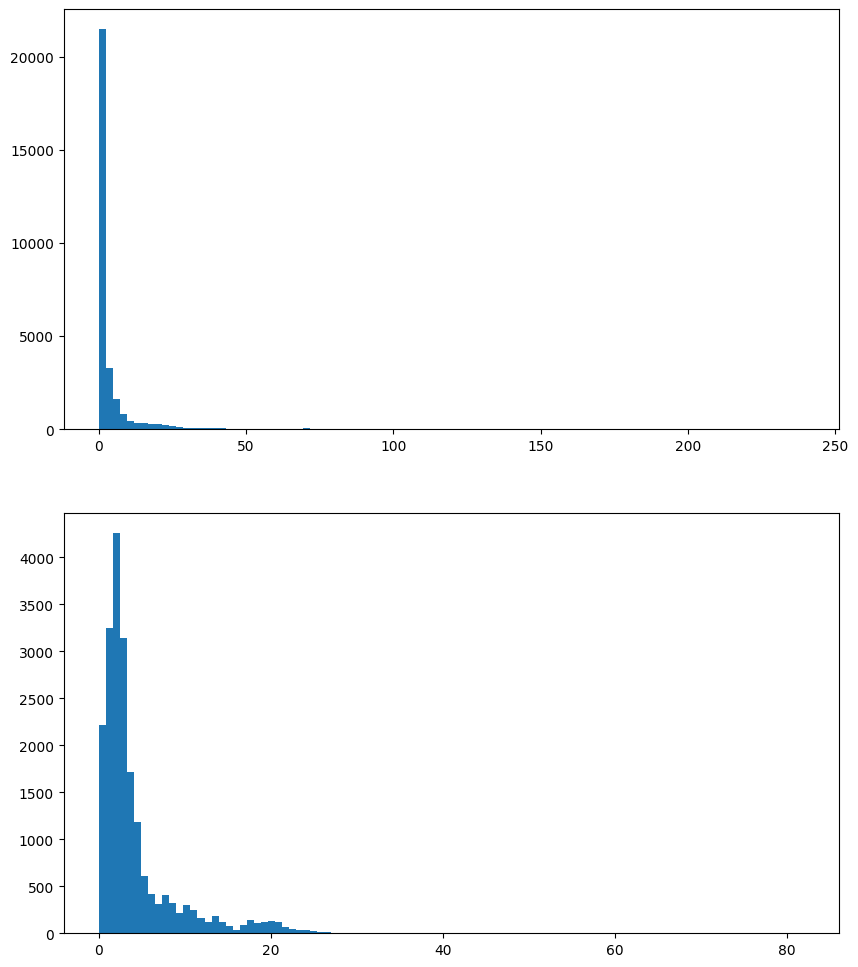

In [4]:
# Open the video file
cap = cv2.VideoCapture("../resources/videos/video2.mp4")

# Check if the video file is opened successfully
if not cap.isOpened():
	print("Error: Could not open video file.")
	exit()

is_background_set = False
background_image = None
overlay = None
keys = None
labels = None
segmentation = None

keys_hist_w = np.array([])
keys_hist_b = np.array([])

while True:
	# Read the frame
	ret, frame = cap.read()
	# Check if the frame is read successfully
	if not ret:
		break
	
	result = frame.copy()
	if (not is_background_set):
		is_background_set = True
		background_image = frame
		overlay, keys, labels, segmentation = process_background_image(background_image)
	else:
		detected_hands, mask, x_ranges_of_interest = find_hand_and_shadow_mask(background_image, frame)
		pressed_keys, metrics_w, metrics_b, border_mask = detect_pressed_keys(keys, x_ranges_of_interest, segmentation, background_image, frame, mask)
		pressed_keys_overlay = generate_pressed_keys_overlay(segmentation, pressed_keys)
		result = cv2.add(result, pressed_keys_overlay)
		keys_hist_w = np.concatenate((keys_hist_w, np.array(metrics_w)))
		keys_hist_b = np.concatenate((keys_hist_b, np.array(metrics_b)))
		cv2.imshow('Hand and Shadow-mask', mask)
		gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
		# cv2.imshow("borders",np.where(border_mask, gray, 0))

	result = add_without_blend(result,overlay)

	# Display the overlayed frame
	cv2.imshow('Overlayed Video', result)
	

	# Wait for a key press to exit or continue processing
	if cv2.waitKey(25) & 0xFF == ord('q'):
		break
fig, axs = plt.subplots(2,1, figsize=(10,12))
axs[0].hist(keys_hist_w, bins=100)
axs[1].hist(keys_hist_b, bins=100)
plt.show()
# Release the video capture object and close any OpenCV windows
cap.release()
cv2.destroyAllWindows()